In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import dask.dataframe as dd
from rasterio.transform import from_origin
import numpy as np
import rasterio
from shapely.ops import unary_union

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
if lng:
    lon = lng

In [4]:
lonlat=(lon, lat)

In [5]:
buildings = gpd.read_parquet(f"../output/{place}/buildings_morphometric_p3.pq")
tessellation = gpd.read_parquet(f"../output/{place}/tessellation_morphometric_p3.pq")
edges = gpd.read_parquet(f"../output/{place}/edges_p4.pq")
nodes = gpd.read_parquet(f"../output/{place}/nodes_p4.pq")
stroke = gpd.read_parquet(f"../output/{place}/stroke_p3.pq")

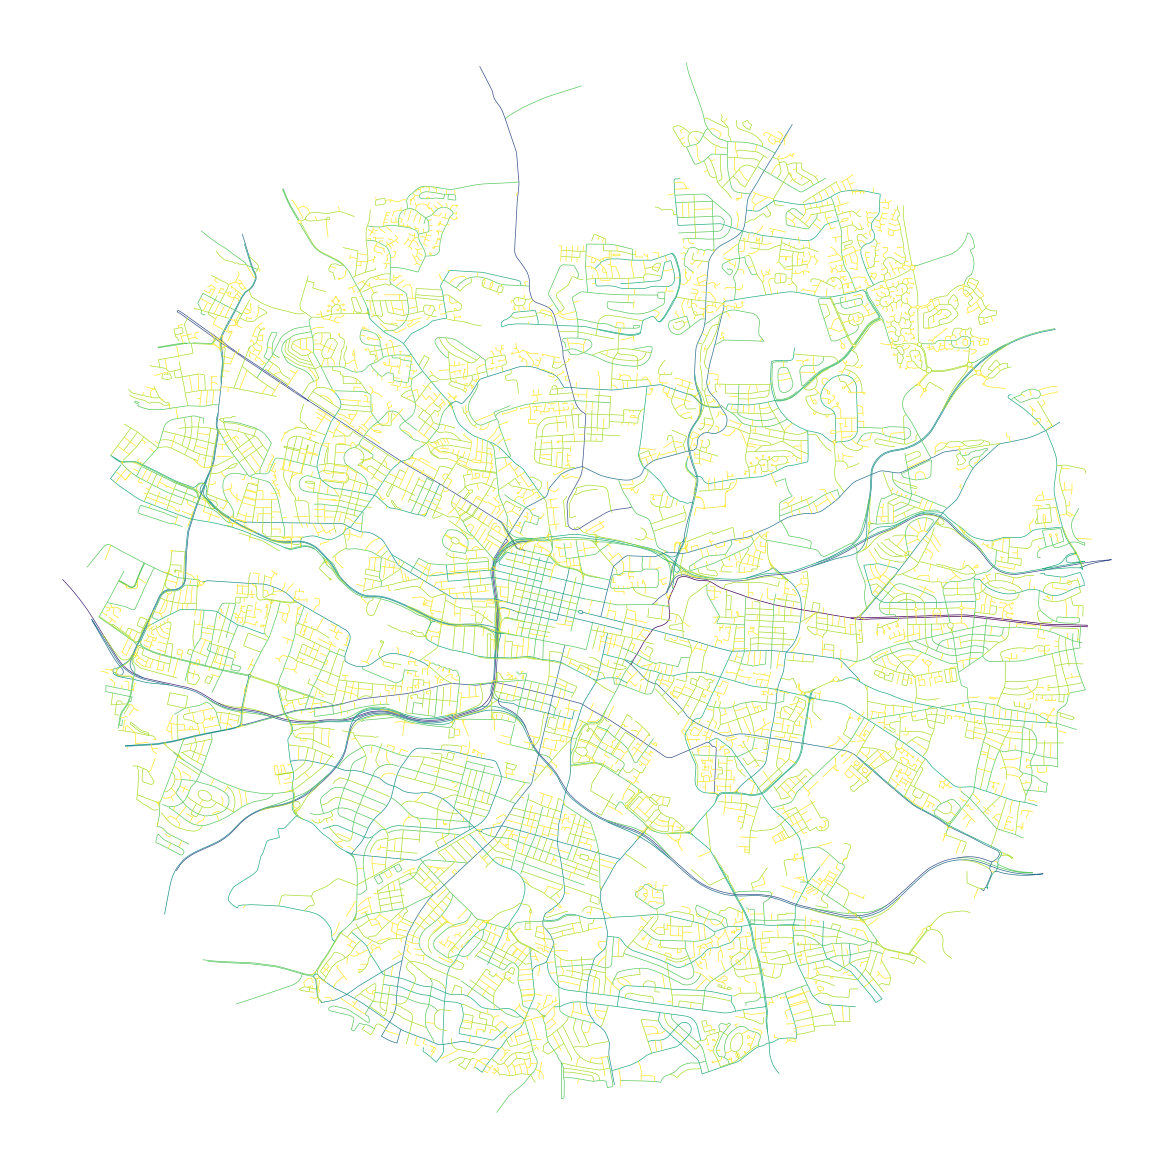

In [6]:
stroke.plot(stroke.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

In [7]:
stroke["stroke_length"] = stroke.length
stroke = stroke.drop(columns=["n_segments"])

In [8]:
buildings_merged = buildings.merge(tessellation.drop(columns=['geometry']), on='uID', how='inner')
buildings_merged_centroids = buildings_merged
buildings_merged_centroids["geometry"] = buildings_merged_centroids['geometry'].centroid

In [9]:
# Your latitude and longitude tuple (latitude, longitude)

# Transform the coordinates
centre_point_4326 = Point(lon, lat)
x_centre, y_centre = transform(4326, local_crs, lat, lon)
centre_point_local_crs = Point(x_centre, y_centre)

/tmp/ipykernel_5365/4192890295.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_centre, y_centre = transform(4326, local_crs, lat, lon)


## Linear Regression

In [10]:
buildings_merged_centroids['distance_to_centre'] = buildings_merged_centroids['geometry'].distance(centre_point_4326)
buildings_merged = buildings_merged_centroids.drop(columns=["uID", "geometry"])
buildings_merged = buildings_merged.dropna()

In [11]:
# Response variable
y = buildings_merged['distance_to_centre']

# Feature variables (excluding the response variable)
X = buildings_merged.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")

Number of Observations: 45717
R-squared: 0.17593161927789358
Adjusted R-squared: 0.17548072720903862
F-statistic: 390.18565956297687



In [12]:
summary_df

Coefficient  \
buildings_neighbours_200                              1005.891645   
building_area                                           23.210615   
building_circular_compactness                         -322.530351   
building_elongation                                    124.426654   
building_squareness                                    -13.996796   
building_eri                                            28.422819   
building_orientation                                    95.397338   
building_neighbour_dist                                  3.316139   
building_neighbourhood_interbuilding_distance           23.777280   
building_circular_compactness_weight                  -285.296206   
building_elongation_weight                             574.668315   
building_squareness_weight                             -88.610645   
building_eri_weight                                    510.740734   
building_neighbour_dist_weight                        -406.603644   
building_neighbourhood_interbuilding_distance_w...     385.429988   
building_orientation_weight                           -382.690224   
tess_area                                              -41.354948   
tessellation_neighbours                                 36.229545   
tess_convexity                                        -102.310163   
tess_covered_area                                       62.825404   
tess_orientation                                       -86.057254   
tess_convexity_weight                                   59.210667   
tess_covered_area_weight                               261.806334   
tess_orientation_weight                                103.313143   
tess_rea_theil                                         478.678753   
Intercept                                           714593.293135   

                                                    Standard Error    t value  \
buildings_neighbours_200                                 20.796051  48.369359   
building_area                                            16.794891   1.382005   
building_circular_compactness                            40.275622  -8.008079   
building_elongation                                      33.817494   3.679358   
building_squareness                                      16.351138  -0.856014   
building_eri                                             26.945368   1.054831   
building_orientation                                     20.556638   4.640707   
building_neighbour_dist                                  23.915808   0.138659   
building_neighbourhood_interbuilding_distance            35.879476   0.662699   
building_circular_compactness_weight                     56.140762  -5.081801   
building_elongation_weight                               42.029197  13.673074   
building_squareness_weight                               21.494572  -4.122466   
building_eri_weight                                      38.178563  13.377684   
building_neighbour_dist_weight                           34.597366 -11.752445   
building_neighbourhood_interbuilding_distance_w...       42.201017   9.133192   
building_orientation_weight                              27.922078 -13.705650   
tess_area                                                25.912636  -1.595938   
tessellation_neighbours                                  18.909900   1.915904   
tess_convexity                                           15.858000  -6.451644   
tess_covered_area                                        29.956895   2.097193   
tess_orientation                                         18.041304  -4.770013   
tess_convexity_weight                                    17.351632   3.412398   
tess_covered_area_weight                                 27.662892   9.464171   
tess_orientation_weight                                  25.489173   4.053217   
tess_rea_theil                                           20.164603  23.738565   
Intercept                                                      NaN        NaN   

  

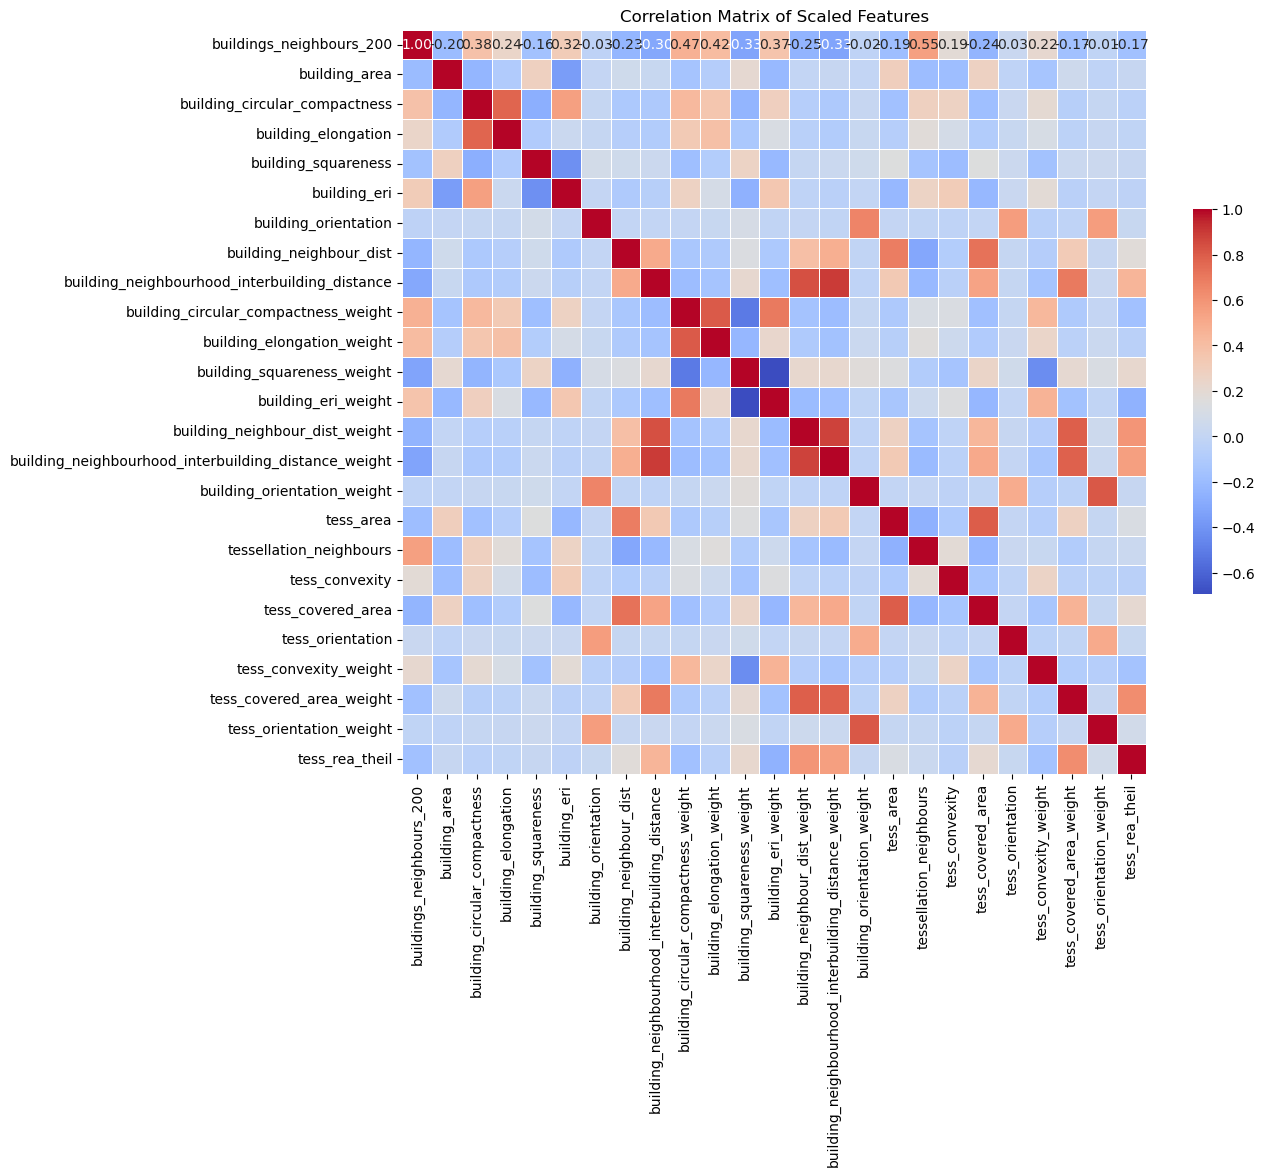

In [13]:
# Convert the numpy array back to a pandas DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adding title
plt.title('Correlation Matrix of Scaled Features')

# Show the plot
plt.show()

In [14]:
residuals = y - predictions

In [15]:
# # Creating a residual plot with Seaborn
# plt.figure(figsize=(10, 6))
# sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.05, 's': 10}, line_kws={'color': 'red'})
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Seaborn Residual Plot')
# plt.show()

In [16]:
# plt.figure(figsize=(8, 6))
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Residuals')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Ordered Values')
# plt.show()

In [17]:
raster_data = gpd.read_parquet(f"../output/{place}/raster_data.pq").to_crs(local_crs)

In [18]:
raster_data

row  col                                           geometry  \
25     1    1  POLYGON ((258152.826 666750.824, 258242.464 66...   
26     1    2  POLYGON ((258242.464 666747.884, 258332.103 66...   
27     1    3  POLYGON ((258332.103 666744.946, 258421.741 66...   
28     1    4  POLYGON ((258421.741 666742.010, 258511.379 66...   
29     1    5  POLYGON ((258511.379 666739.076, 258601.017 66...   
..   ...  ...                                                ...   
450   18   18  POLYGON ((259689.142 664800.088, 259778.795 66...   
451   18   19  POLYGON ((259778.795 664797.182, 259868.448 66...   
452   18   20  POLYGON ((259868.448 664794.277, 259958.101 66...   
453   18   21  POLYGON ((259958.101 664791.375, 260047.755 66...   
454   18   22  POLYGON ((260047.755 664788.474, 260137.408 66...   

     GHS_BUILT_H_100  GHS_BUILT_S_100  GHS_BUILT_V_100  GHS_LAND_100  \
25                 4             4153            45216         10000   
26                 4             3859            47041         10000   
27                 4             3158            41401         10000   
28                 4             3671            42689          9905   
29                 2             2775            24379          9993   
..               ...              ...              ...           ...   
450                2             3497            27740         10000   
451                2             3634            27486         10000   
452                2             3971            29085         10000   
453                3             5452            38809         10000   
454                2             2978            21039         10000   

     GHS_POP_100  
25           133  
26           122  
27            88  
28           115  
29            72  
..           ...  
450          195  
451          148  
452           42  
453           21  
454           17  

[403 rows x 8 columns]

In [19]:
# Create a 50 km buffer around the point
buffer_circle = gpd.GeoDataFrame({'geometry': [Point(lon, lat)]}, crs=4326).to_crs(local_crs).buffer(radius * 1000)

In [20]:
# Get bounds
minx, miny, maxx, maxy = raster_data.total_bounds
min_dist = min([abs(minx-lonlat[1]), abs(miny-lonlat[0]), abs(maxx-lonlat[1]), abs(maxy-lonlat[0])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(lonlat[0], lonlat[1])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((lonlat[0] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if lonlat[1] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius) * 1000).to_crs(local_crs)  # Convert km to meters

In [21]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first GeoDataFrame
# cells_in_circle.plot(ax=ax, color='blue', edgecolor='k', alpha=0.2)  # Adjust color and edgecolor as needed

# # Plot the second GeoDataFrame on the same axes
# buffer_circle.plot(ax=ax, color='red', alpha=0.2)  # Adjust color and alpha for transparency as needed

# tessellation.plot(ax=ax, color="green", alpha=0.4)

# # Optionally set axis limits or other plot properties
# # ax.set_xlim([xmin, xmax])
# # ax.set_ylim([ymin, ymax])

# ctx.add_basemap(ax, crs=local_crs,source=ctx.providers.CartoDB.Positron)

# plt.show()

In [22]:
cells_in_circle = raster_data[raster_data["geometry"].within(buffer_circle.geometry[0])]


<Axes: >

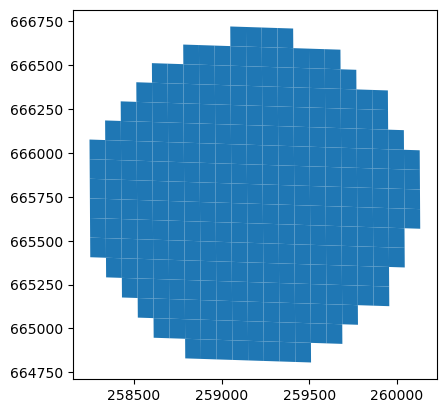

In [23]:
cells_in_circle.plot()

In [24]:
cells_in_circle

row  col                                           geometry  \
35     1   11  POLYGON ((259049.210 666721.509, 259138.848 66...   
36     1   12  POLYGON ((259138.848 666718.588, 259228.487 66...   
37     1   13  POLYGON ((259228.487 666715.669, 259318.125 66...   
38     1   14  POLYGON ((259318.125 666712.751, 259407.764 66...   
56     2    8  POLYGON ((258781.018 666618.451, 258870.658 66...   
..   ...  ...                                                ...   
419   17   11  POLYGON ((259060.845 664932.302, 259150.496 66...   
420   17   12  POLYGON ((259150.496 664929.382, 259240.148 66...   
421   17   13  POLYGON ((259240.148 664926.464, 259329.800 66...   
422   17   14  POLYGON ((259329.800 664923.549, 259419.452 66...   
423   17   15  POLYGON ((259419.452 664920.635, 259509.105 66...   

     GHS_BUILT_H_100  GHS_BUILT_S_100  GHS_BUILT_V_100  GHS_LAND_100  \
35                 0              743             6032         10000   
36                 2             2839            22843          9857   
37                 1             1839            14617          9218   
38                 1             1357            10210          7757   
56                 2             3384            27651         10000   
..               ...              ...              ...           ...   
419                6             6301            69643         10000   
420                8             7642            82925          9996   
421                4             4785            49913         10000   
422                5             5760            56003         10000   
423                3             4323            38626         10000   

     GHS_POP_100  
35             0  
36             1  
37             1  
38             5  
56             3  
..           ...  
419            1  
420            0  
421           18  
422           18  
423           42  

[272 rows x 8 columns]

In [25]:
# cells_in_circle.explore()

In [26]:
# # Assuming cells_in_circle is a GeoDataFrame
# fig, ax = plt.subplots()
# cells_in_circle.plot(column='row', ax=ax, cmap='Blues')
# plt.show()

In [27]:
buildings

uID                                           geometry  \
0          0  POLYGON ((253894.911 667992.009, 253874.743 66...   
1          1  POLYGON ((257873.072 660535.923, 257814.018 66...   
2          2  POLYGON ((260781.284 667382.518, 260780.702 66...   
3          3  POLYGON ((258731.422 660456.589, 258651.296 66...   
4          4  POLYGON ((254252.042 665895.371, 254246.914 66...   
...      ...                                                ...   
45789  45789  POLYGON ((261598.050 664298.257, 261581.647 66...   
45790  45790  POLYGON ((263173.291 664689.249, 263194.421 66...   
45791  45791  POLYGON ((262230.343 670792.684, 262237.303 67...   
45792  45792  POLYGON ((262847.006 666028.488, 262817.617 66...   
45793  45793  POLYGON ((261524.300 664088.654, 261521.701 66...   

       buildings_neighbours_200  building_area  building_circular_compactness  \
0                      0.675022     393.721492                       0.611691   
1                      0.621642     517.390250                       0.180988   
2                      1.407936       6.472399                       0.425697   
3                      0.325147    1530.778738                       0.129518   
4                      0.188593    1011.766821                       0.330530   
...                         ...            ...                            ...   
45789                  1.617087     159.896719                       0.498677   
45790                  1.421154     192.046387                       0.459999   
45791                  3.926341      78.225339                       0.599314   
45792                  1.225515     336.773661                       0.418357   
45793                  1.426849     201.254981                       0.528510   

       building_elongation  building_squareness  building_eri  \
0                 0.977598             0.023740      0.811813   
1                 0.145153             0.027922      1.000026   
2                 0.383786             0.077274      1.000115   
3                 0.131325             0.121170      0.863361   
4                 0.464872             0.012413      0.716023   
...                    ...                  ...           ...   
45789             0.511688             0.084276      0.982110   
45790             0.427381             0.025262      1.000018   
45791             0.706189             0.086031      1.000091   
45792             0.374840             0.039373      1.000058   
45793             0.533222             0.022144      1.000031   

       building_orientation  building_neighbour_dist  \
0                  3.700646                11.330833   
1                  8.449315                13.229783   
2                 21.588409                20.688586   
3                 39.274035                23.254436   
4                  5.196538                59.918546   
...                     ...                      ...   
45789             24.291513                12.400708   
45790              4.560922                20.101612   
45791             20.694099                 3.557106   
45792             11.308662                14.884064   
45793              7.686966                12.000327   

       building_neighbourhood_interbuilding_distance  \
0                                          29.068026   
1                                          17.489447   
2                                          52.429304   
3                                          23.060214   
4                                          55.311051   
...                                              ...   
45789                                      17.920671   
45790                                      23.773267   
45791                                      19.922841   
45792                                      20.839199   
45793                                      16.675851   

       building_circular_compactness_weight  building_elongation_weight  \
0                            

In [28]:
cells_in_circle.reset_index()[["geometry", "row", "col"]]

geometry  row  col
0    POLYGON ((259049.210 666721.509, 259138.848 66...    1   11
1    POLYGON ((259138.848 666718.588, 259228.487 66...    1   12
2    POLYGON ((259228.487 666715.669, 259318.125 66...    1   13
3    POLYGON ((259318.125 666712.751, 259407.764 66...    1   14
4    POLYGON ((258781.018 666618.451, 258870.658 66...    2    8
..                                                 ...  ...  ...
267  POLYGON ((259060.845 664932.302, 259150.496 66...   17   11
268  POLYGON ((259150.496 664929.382, 259240.148 66...   17   12
269  POLYGON ((259240.148 664926.464, 259329.800 66...   17   13
270  POLYGON ((259329.800 664923.549, 259419.452 66...   17   14
271  POLYGON ((259419.452 664920.635, 259509.105 66...   17   15

[272 rows x 3 columns]

In [29]:
buildings_joint = buildings.sjoin(cells_in_circle.reset_index()[["geometry", "row", "col"]], how='inner', op="intersects")

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
# buildings_joint.explore()

In [31]:
joint_gdf = tessellation.join(buildings_joint, on="uID", how="inner", lsuffix="_tess", rsuffix="_build").drop(["uID_tess"], axis=1)

In [32]:
joint_gdf.set_geometry("geometry_build")

uID                                      geometry_tess     tess_area  \
59        59  POLYGON ((259894.641 666125.219, 259894.142 66...   4267.678152   
85        85  POLYGON ((259827.291 665376.778, 259826.852 66...   1190.286709   
99        99  POLYGON ((259851.838 665203.400, 259852.094 66...   6158.476863   
99        99  POLYGON ((259851.838 665203.400, 259852.094 66...   6158.476863   
173      173  POLYGON ((259414.169 665314.481, 259410.427 66...   7504.572322   
...      ...                                                ...           ...   
28666  28666  POLYGON ((259458.880 665503.216, 259459.130 66...  26497.694903   
28698  28698  POLYGON ((258480.370 665118.350, 258479.896 66...   3728.140464   
28731  28731  POLYGON ((259283.182 666348.714, 259286.617 66...   6421.419306   
28824  28824  POLYGON ((259436.201 665093.521, 259436.091 66...   2248.192287   
28824  28824  POLYGON ((259436.201 665093.521, 259436.091 66...   2248.192287   

       tessellation_neighbours  tess_convexity  tess_covered_area  \
59                    0.082119        0.890109       36455.970181   
85                    0.277504        0.792370       35164.205771   
99                    0.137401        0.947574       34675.058111   
99                    0.137401        0.947574       34675.058111   
173                   0.208843        0.989516       77080.895702   
...                        ...             ...                ...   
28666                 0.150232        0.934039      157620.881939   
28698                 0.270792        0.997236       65776.759325   
28731                 0.092155        0.933238       25957.832461   
28824                 0.157815        0.815169       31186.788669   
28824                 0.157815        0.815169       31186.788669   

       tess_orientation  tess_convexity_weight  tess_covered_area_weight  \
59             7.755103               0.940297              47142.767419   
85             0.875672               0.911587              85338.792369   
99            19.556933               0.934319              59060.729909   
99            19.556933               0.934319              59060.729909   
173           12.648022               0.909992             148447.135743   
...                 ...                    ...                       ...   
28666          4.858626               0.909369             101570.123064   
28698         10.786593               0.920305             156077.069689   
28731         38.403327               0.897652              46840.908004   
28824         13.906715               0.934215             137379.505421   
28824         13.906715               0.934215             137379.505421   

       tess_orientation_weight  ...  building_circular_compactness_weight  \
59                    9.014116  ...                              0.514960   
85                   11.957124  ...                              0.381519   
99                   20.511396  ...                              0.421523   
99                   20.511396  ...                              0.421523   
173                  12.577029  ...                              0.424051   
...                        ...  ...                                   ...   
28666                12.187053  ...                              0.423425   
28698                10.121905  ...                              0.332136   
28731                24.172211  ...                              0.383946   
28824                15.447051  ...                              0.456585   
28824                15.447051  ...                              0.456585   

       building_elongation_weight building_squareness_weight  \
59                       0.698092                   0.842517   
85                       0.549922                  14.541781   
99                       0.649005                  11.640162   
99                       0.649005                  11.640162   
173                      0.693303                

In [33]:
tessellation_not_in_buildings = tessellation[~tessellation['uID'].isin(buildings_joint['uID'])]

<Axes: >

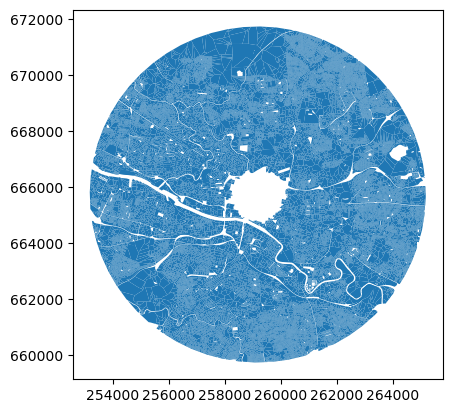

In [34]:
tessellation_not_in_buildings.plot()

In [35]:
joint_gdf = joint_gdf.set_geometry("geometry_build")

In [36]:
joint_gdf.to_parquet(f"../output/{place}/p5-buildings-output.pq")

In [37]:
# Create a copy of the joint_gdf to avoid modifying the original while iterating
joint_gdf_copy = joint_gdf.copy()

# List to hold the new rows
new_rows = []

for index, row in joint_gdf.iterrows():
    for x in range(-1, 2):  # Adjusted range to include -1, 0, 1
        for y in range(-1, 2):  # Adjusted range to include -1, 0, 1
            if x == 0 and y == 0:  # Skip the current cell
                continue
            else:
                # Copy the current row and modify 'row' and 'col'
                new_row = row.copy()
                new_row["row"] += x
                new_row["col"] += y
                new_rows.append(new_row)

# Convert the list of new rows to a GeoDataFrame and concatenate it with the original
new_rows_gdf = gpd.GeoDataFrame(new_rows)
joint_gdf = pd.concat([joint_gdf_copy, new_rows_gdf], ignore_index=True)


In [38]:
# Assuming 'gdf' is your GeoDataFrame
# Convert GeoDataFrame to Dask DataFrame
dask_df = dd.from_pandas(joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right"], axis=1), npartitions=10)  # You can adjust the number of partitions

# Group by 'row' and 'col'
grouped = dask_df.groupby(["row", "col"])

stats_df = grouped.aggregate(['median'], shuffle='tasks').compute()

In [39]:
out = {}

for column in joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right", "row", "col"], axis=1).columns:
    print(column)
    q25 = grouped[column].apply(lambda x: x.quantile(0.25), meta=('x', 'f8')).compute()
    q25.name = f"q25"
    q75 = grouped[column].apply(lambda x: x.quantile(0.75), meta=('x', 'f8')).compute()
    q75.name = f"q75"
    # kurtosis = grouped[column].apply(lambda x: x.kurtosis(), meta=('x', 'f8')).compute()
    # kurtosis.name = f"kurtosis"
    # skew =  grouped[column].apply(lambda x: x.skew(), meta=('x', 'f8')).compute()
    # skew.name = f"skew"
    
    out[column] = [stats_df[column], q25, q75]


tess_area
tessellation_neighbours
tess_convexity
tess_covered_area
tess_orientation
tess_convexity_weight
tess_covered_area_weight
tess_orientation_weight
tess_rea_theil
buildings_neighbours_200
building_area
building_circular_compactness
building_elongation
building_squareness
building_eri
building_orientation
building_neighbour_dist
building_neighbourhood_interbuilding_distance
building_circular_compactness_weight
building_elongation_weight
building_squareness_weight
building_eri_weight
building_neighbour_dist_weight
building_neighbourhood_interbuilding_distance_weight
building_orientation_weight


In [40]:
concat_df = pd.DataFrame()

In [41]:
for key in out:
    # Concatenate the Series
    concatenated = pd.concat(out[key], axis=1)

    # Create a MultiIndex using the key and the column names of the concatenated DataFrame
    multi_index = pd.MultiIndex.from_tuples([(key, col) for col in concatenated.columns])

    # Set the MultiIndex to the concatenated DataFrame
    concatenated.columns = multi_index

    # Combine the concatenated DataFrame into stats_df
    concat_df = pd.concat([concat_df, concatenated], axis=1)

In [42]:
# Assume df is your DataFrame

# Transpose the DataFrame
df_transposed = concat_df.T

# Find duplicated rows (originally columns)
duplicates = df_transposed.duplicated()

# List out the names of duplicate columns
duplicate_columns = df_transposed.index[duplicates].tolist()

# Print or process the duplicate column names
print("Duplicate columns:", duplicate_columns)

Duplicate columns: []


In [43]:
# Calculate the count of entries in each cell
cell_counts = dask_df.groupby(['row', 'col']).size().compute()
cell_counts_df = cell_counts.reset_index(name='entry_count')

In [44]:
concat_df

tess_area                             tessellation_neighbours  \
               median           q25           q75                  median   
row col                                                                     
5   20    6608.405596   4658.399430   8222.970961                0.098272   
12  19    3345.593685   2183.957779   9158.998481                0.160270   
14  20    5678.075163   2694.049688   6946.596752                0.139944   
    19    5258.714810   2564.801374   6910.360351                0.155792   
    14    6308.048325   2248.192287   8791.497251                0.157815   
...               ...           ...           ...                     ...   
1   9    15530.125852  14963.221588  16097.030116                0.055915   
2   9    14396.317325  14396.317325  15530.125852                0.070290   
0   12    3773.229291   3773.229291   3773.229291                0.046407   
3   4     5857.907405   3364.276778   8351.538032                0.128662   
17  18    6825.613535   6320.496004   9447.195989                0.169390   

                            tess_convexity                      \
              q25       q75         median       q25       q75   
row col                                                          
5   20   0.067767  0.101149       0.923577  0.900209  0.966882   
12  19   0.143848  0.213942       0.910727  0.891613  0.972147   
14  20   0.134007  0.160270       0.947574  0.889982  0.973836   
    19   0.134943  0.180249       0.944716  0.861820  0.972709   
    14   0.126668  0.208843       0.989516  0.877318  0.996302   
...           ...       ...            ...       ...       ...   
1   9    0.048728  0.063103       0.625969  0.560339  0.691599   
2   9    0.055915  0.070290       0.757228  0.625969  0.757228   
0   12   0.046407  0.046407       0.864954  0.864954  0.864954   
3   4    0.092215  0.165109       0.918124  0.886227  0.950021   
17  18   0.159292  0.176629       0.968585  0.958562  0.976717   

        tess_covered_area  ... building_eri_weight  \
                   median  ...                 q75   
row col                    ...                       
5   20       44911.201357  ...            0.901855   
12  19       32172.946082  ...            0.798901   
14  20       34172.401614  ...            0.824216   
    19       34675.058111  ...            0.824216   
    14       52018.903413  ...            0.802696   
...                   ...  ...                 ...   
1   9        82990.195910  ...            0.834527   
2   9        62928.267797  ...            0.833506   
0   12       14309.783863  ...            0.858512   
3   4        28593.413205  ...            0.681666   
17  18       47009.434551  ...            0.784714   

        building_neighbour_dist_weight                        \
                                median        q25        q75   
row col                                                        
5   20                       38.645858  36.959649  39.873226   
12  19                       26.651356  25.381727  27.206551   
14  20                       29.030713  27.417595  30.146879   
    19                       25.757533  25.027905  29.030713   
    14                       19.750114  17.667760  21.869791   
...                                ...        ...        ...   
1   9                        37.142971  36.520132  37.765810   
2   9                        35.897293  35.897293  37.142971   
0   12                       36.925605  36.925605  36.925605   
3   4                        21.979896  21.934590  22.025203   
17  18                       23.000276  22.763263  23.421098   

        building_neighbourhood_interbuilding_distance_weight             \
                                                      median        q25   
row col                                                                   
5   20                                           34.339812    33.673501   
12  19                                           26.31

In [45]:
raster_data

row  col                                           geometry  \
25     1    1  POLYGON ((258152.826 666750.824, 258242.464 66...   
26     1    2  POLYGON ((258242.464 666747.884, 258332.103 66...   
27     1    3  POLYGON ((258332.103 666744.946, 258421.741 66...   
28     1    4  POLYGON ((258421.741 666742.010, 258511.379 66...   
29     1    5  POLYGON ((258511.379 666739.076, 258601.017 66...   
..   ...  ...                                                ...   
450   18   18  POLYGON ((259689.142 664800.088, 259778.795 66...   
451   18   19  POLYGON ((259778.795 664797.182, 259868.448 66...   
452   18   20  POLYGON ((259868.448 664794.277, 259958.101 66...   
453   18   21  POLYGON ((259958.101 664791.375, 260047.755 66...   
454   18   22  POLYGON ((260047.755 664788.474, 260137.408 66...   

     GHS_BUILT_H_100  GHS_BUILT_S_100  GHS_BUILT_V_100  GHS_LAND_100  \
25                 4             4153            45216         10000   
26                 4             3859            47041         10000   
27                 4             3158            41401         10000   
28                 4             3671            42689          9905   
29                 2             2775            24379          9993   
..               ...              ...              ...           ...   
450                2             3497            27740         10000   
451                2             3634            27486         10000   
452                2             3971            29085         10000   
453                3             5452            38809         10000   
454                2             2978            21039         10000   

     GHS_POP_100  
25           133  
26           122  
27            88  
28           115  
29            72  
..           ...  
450          195  
451          148  
452           42  
453           21  
454           17  

[403 rows x 8 columns]

In [46]:
raster_data = raster_data.set_index(["row", "col"])

In [47]:
concat_df = concat_df.dropna()

In [48]:
out_df = gpd.GeoDataFrame(pd.concat([concat_df, raster_data], axis=1).reset_index(), geometry="geometry")
out_df = out_df.merge(cell_counts_df, on=['row', 'col'], how='left')

In [49]:
out_df = out_df.drop(columns=["geometry"], axis=1)
out_df = out_df.merge(cells_in_circle[["geometry", "row", "col"]], on=["row", "col"], how="inner")

In [50]:
out_df = gpd.GeoDataFrame(out_df, geometry='geometry')

In [51]:
# Function to flatten and clean column names (tuples or strings) from the GeoDataFrame
def clean_column_names(columns):
    clean_names = []
    for col in columns:
        if isinstance(col, tuple):
            clean_name = '_'.join(part.strip() for part in col)
        else:
            clean_name = col.strip()
        clean_names.append(clean_name)
    return clean_names

# Apply the cleaning function to the GeoDataFrame columns
out_df.columns = clean_column_names(out_df.columns)
out_df.columns.tolist()

['row',
 'col',
 'tess_area_median',
 'tess_area_q25',
 'tess_area_q75',
 'tessellation_neighbours_median',
 'tessellation_neighbours_q25',
 'tessellation_neighbours_q75',
 'tess_convexity_median',
 'tess_convexity_q25',
 'tess_convexity_q75',
 'tess_covered_area_median',
 'tess_covered_area_q25',
 'tess_covered_area_q75',
 'tess_orientation_median',
 'tess_orientation_q25',
 'tess_orientation_q75',
 'tess_convexity_weight_median',
 'tess_convexity_weight_q25',
 'tess_convexity_weight_q75',
 'tess_covered_area_weight_median',
 'tess_covered_area_weight_q25',
 'tess_covered_area_weight_q75',
 'tess_orientation_weight_median',
 'tess_orientation_weight_q25',
 'tess_orientation_weight_q75',
 'tess_rea_theil_median',
 'tess_rea_theil_q25',
 'tess_rea_theil_q75',
 'buildings_neighbours_200_median',
 'buildings_neighbours_200_q25',
 'buildings_neighbours_200_q75',
 'building_area_median',
 'building_area_q25',
 'building_area_q75',
 'building_circular_compactness_median',
 'building_circular

In [52]:
# out_df.explore()

In [53]:
out_df_expanded = out_df

In [54]:
for index, row in out_df.iterrows():
    geometry_list = [row.geometry]
    for x in range(-1, 2):  # Adjusted range to include -1, 0, 1
        for y in range(-1, 2):  # Adjusted range to include -1, 0, 1
            # Filter out_df for the specific row and column values
            filtered_df = out_df[(out_df["row"] == row.row + x) & (out_df["col"] == row.col + y)]
            # Check if the filtered_df is not empty
            if not filtered_df.empty:
                # Append the geometry of the first row from the filtered dataframe
                geometry_list.append(filtered_df.geometry.iloc[0])
    
    # Update the 'out_df_expanded' with the unified geometry
    out_df_expanded.loc[(out_df_expanded['row'] == row.row) & (out_df_expanded['col'] == row.col), 'geometry'] = unary_union(geometry_list)

In [55]:
def calculate_statistics(name, nodes, out_df):
    # Spatial join - associating each node with a polygon
    joined = gpd.sjoin(nodes, out_df, how='inner', op='intersects')

    # Creating a list to hold results
    results = []

    # Iterating through each unique polygon in the spatial join
    for polygon_id in joined['index_right'].unique():
        # Filter to include only nodes within the current polygon
        nodes_in_polygon = joined[joined['index_right'] == polygon_id]

        # Calculating statistics for each column
        stats = {'polygon_id': polygon_id}
        
        stats[f'nodes_count'] = nodes_in_polygon.iloc[0].count()
        
        for column in nodes.columns:
            if nodes[column].dtype in ['int64', 'float64']:  # Check if column is numeric
                # stats[f'{column}_max'] = nodes_in_polygon[column].max()
                # stats[f'{column}_min'] = nodes_in_polygon[column].min()
                stats[f'{name}_{column}_median'] = nodes_in_polygon[column].median()
                for quantile, value in nodes_in_polygon[column].quantile([0.25, 0.5, 0.75]).items():
                    stats[f'{name}_{column}_quantile_{quantile}'] = value

        # Adding stats for this polygon to the results list
        results.append(stats)

    # Creating a DataFrame from the results
    stats_df = pd.DataFrame(results)

    # Ensuring that the merge key in out_df is a regular column (not an index)
    
    # out_df.explore()
    
    out_df['polygon_id'] = out_df.index

    # Merging the stats DataFrame with the out_df GeoDataFrame
    merged_df = out_df.merge(stats_df, on='polygon_id', how='left')
    
    merged_df = merged_df.drop(columns=["polygon_id"], axis = 1)

    return merged_df

In [56]:
out_df_expanded = calculate_statistics("nodes", nodes, out_df_expanded)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
def calculate_line_statistics(name, edges, out_df):
    # Spatial join - associating each line with polygons it intersects
    joined = gpd.sjoin(edges, out_df, how='inner', op='intersects')

    # Creating a list to hold results
    results = []

    # Iterating through each unique polygon in the spatial join
    for polygon_id in joined['index_right'].unique():
        # Filter to include only lines intersecting the current polygon
        lines_in_polygon = joined[joined['index_right'] == polygon_id]
        
        # Calculating statistics for each column
        stats = {'polygon_id': polygon_id}
        
        stats[f'{name}_count'] = lines_in_polygon.iloc[0].count()

        for column in edges.columns:
            if edges[column].dtype in ['int64', 'float64']:  # Check if column is numeric
                # stats[f'{name}_{column}_max'] = lines_in_polygon[column].max()
                # stats[f'{name}_{column}_min'] = lines_in_polygon[column].min()
                stats[f'{name}_{column}_median'] = lines_in_polygon[column].median()
                for quantile, value in lines_in_polygon[column].quantile([0.25, 0.5, 0.75]).items():
                    stats[f'{name}_{column}_quantile_{quantile}'] = value

        # Adding stats for this polygon to the results list
        results.append(stats)

    # Creating a DataFrame from the results
    stats_df = pd.DataFrame(results)

    # Ensuring that the merge key in out_df is a regular column (not an index)
    out_df['polygon_id'] = out_df.index

    # Merging the stats DataFrame with the out_df GeoDataFrame
    merged_df = out_df.merge(stats_df, on='polygon_id', how="left")

    return merged_df

In [58]:
edges = edges.drop(["mm_len", "node_start", "node_end"], axis=1)

In [59]:
out_df_expanded = calculate_line_statistics("edges", edges, out_df_expanded)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [60]:
out_df_expanded = calculate_line_statistics("strokes", stroke, out_df_expanded)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [61]:
out_df_expanded = out_df_expanded.drop(columns=["geometry"], axis=1)
out_df = out_df_expanded.merge(cells_in_circle[["geometry", "row", "col"]], on=["row", "col"], how="inner")

In [62]:
# Convert the merged DataFrame to a GeoDataFrame
geo_df = gpd.GeoDataFrame(out_df, geometry='geometry')

In [63]:
geo_df = geo_df.drop(columns=["polygon_id"])

In [64]:
# geo_df.explore()

In [65]:
geo_df.to_parquet(f"../output/{place}/p5-grid-output.pq")

In [66]:
# with rasterio.open(f'../output/{place}/p5.tif') as src:
#     # Get the transform object
#     transform = src.transform

#     # Extract west, north, and resolution (xres, yres)
#     west = transform.c
#     north = transform.f
#     xres = transform.a
#     yres = -transform.e  # yres is negative as raster origin is top-left


In [67]:

# # Open the source raster to get the transform
# with rasterio.open(f'../output/{place}.tif') as src:
#     transform = src.transform

#     west = transform.c
#     north = transform.f
#     xres = transform.a
#     yres = -transform.e  # yres is negative as raster origin is top-left

# # Calculate raster dimensions
# n_rows = gdf['row'].max() - gdf['row'].min() + 1
# n_cols = gdf['col'].max() - gdf['col'].min() + 1

# # List of columns to be used as bands
# band_columns = [col for col in gdf.columns if col not in ['row', 'col', 'geometry']]

# # Initialize raster dataset
# with rasterio.open(f"../output/{place}/grid_with_summary_stats.tif", 'w', 
#     driver='GTiff', 
#     height=n_rows, 
#     width=n_cols, 
#     count=len(band_columns), 
#     dtype=str(gdf[band_columns[0]].dtype), 
#     crs=gdf.crs, 
#     transform=transform
# ) as dst:
#     for i, column in enumerate(band_columns, start=1):
#         # Create an empty array filled with NaNs (or use a different no-data value)
#         if column == 'building_height':
#             # For 'building_height', initialize with zeros
#             band_data = np.zeros((n_rows, n_cols))
#         else:
#             # For other columns, initialize with NaNs
#             band_data = np.full((n_rows, n_cols), np.nan)

#         # Update the array with data from the GeoDataFrame
#         for _, row in gdf.iterrows():
#             row_idx, col_idx = row['row'] - gdf['row'].min(), row['col'] - gdf['col'].min()
#             band_data[row_idx, col_idx] = row[column]

#         dst.write(band_data, i)

In [68]:
# gdf['distance_to_centre'] = gdf['geometry'].distance(centre_point_local_crs)

In [69]:
# new_gdf = gdf.drop(columns=["geometry", "row", "col"]).dropna()

In [70]:
# # Response variable
# y = new_gdf['distance_to_centre']

# # Feature variables (excluding the response variable)
# X = new_gdf.drop(columns=['distance_to_centre'])

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Initialize and fit the Linear Regression model
# model = LinearRegression()
# model.fit(X_scaled, y)

# # Coefficients and Intercept
# coefficients = model.coef_
# intercept = model.intercept_

# # Predictions
# predictions = model.predict(X_scaled)

# # Number of observations and number of features
# n = len(y)
# p = X.shape[1]

# # Residual Sum of Squares and Total Sum of Squares
# rss = np.sum((y - predictions) ** 2)
# tss = np.sum((y - np.mean(y)) ** 2)

# # R-squared and Adjusted R-squared
# r_squared = 1 - (rss / tss)
# adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# # Standard Error of the coefficients
# mse = rss / (n - p - 1)
# se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# # t-statistics and p-values for coefficients
# t_stats = coefficients / se
# p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# # F-statistic
# f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

# def get_significance_asterisks(p):
#     if p < 0.001:
#         return '***'
#     elif p < 0.01:
#         return '**'
#     elif p < 0.05:
#         return '*'
#     else:
#         return ''

# # Create a summary DataFrame
# summary_df = pd.DataFrame({
#     'Coefficient': coefficients,
#     'Standard Error': se,
#     't value': t_stats,
#     'p value': p_values,
#     'Significance': [get_significance_asterisks(p) for p in p_values]
# }, index=X.columns)
# summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# # Print summary statistics
# print(f"Number of Observations: {n}")
# print(f"R-squared: {r_squared}")
# print(f"Adjusted R-squared: {adjusted_r_squared}")
# print(f"F-statistic: {f_statistic}\n")

In [71]:
# summary_df.to_string()

In [72]:
# # Assuming 'summary_df' is your DataFrame
# # Set the display options
# pd.set_option('display.max_rows', None)  # Replace None with a specific number if the DataFrame is very large
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)  # Adjust the width for better readability if necessary
# pd.set_option('display.max_colwidth', None)  # Adjust column width to show full content of each cell

In [73]:
# summary_df

In [74]:
# summary_df.to_parquet(f"../output/{place}/summary_df.pq")